In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39115")
client

<Client: 'tcp://127.0.0.1:39115' processes=10 threads=50, memory=196.73 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

dCs = 1e-5
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

/tmp/ipykernel_19228/3829648471.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs


$$\eta_K = \frac{1}{C_\Psi}\int_{\kappa>k} \mathcal{R}\left[ \overline{\tilde{q'}^*\widetilde{\nabla\cdot\overline{\boldsymbol{v}}q'}} + \overline{\tilde{q'}^*\widetilde{\nabla\cdot\boldsymbol{v}'q'}} + \overline{\widetilde{q'\boldsymbol{v}'}^*\cdot\widetilde{\nabla\overline{q}}} + \tilde{\overline{q}}^*\widetilde{\nabla\cdot\overline{\boldsymbol{v}'q'}}\right] x_0^2 \kappa\, d\kappa$$

# Wavelet
## Native grid

In [7]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:
            
            dsgrd = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (0,years[0])), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    iters=ntimes[0,0],
                                    prefix=['diag_ocnSnap'], delta_t=2e2,
                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                        )
            
            dsq = xr.open_zarr(op.join(tdgs,
                                       '5Dave/run%4d/EddyErtelPV/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                    XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                   ).chunk({'Z':1})
            
            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                          YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                          XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                          XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
            
            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                              XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                              XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         YG=slice(ys[reg]-5-2/12,ys[reg]+5+2/12),
                                                         XC=slice(xs[reg]-5-2/12,xs[reg]+5+2/12),
                                                         XG=slice(xs[reg]-5-2/12,xs[reg]+5+2/12)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

        
            grid = Grid(ds, periodic=[])

            v = ds.VVEL.where(ds.maskS!=0.)
            u = ds.UVEL.where(ds.maskW!=0.)
            w = ds.WVEL
            up = (u - dsb.UVEL).where(ds.maskW!=0.)
            vp = (v - dsb.VVEL).where(ds.maskS!=0.)
            wp = (w - dsb.WVEL)
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)

            rho_til = grid.interp(rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                                    boundary='extend')
                                                      )),
                                  'Z', boundary='extend'
                                 )
            pres = rhoConst*grav*(-ds.Z) * 1e-4
            rho = xr.apply_ufunc(densjmd95, salt, theta, 
                                 pres, 
                                 dask='parallelized', output_dtypes=[float,]
                                )
            b = -(rho - rho_til) / rhoConst

            zeta = grid.interp(grid.interp((grid.diff(v*ds.dyC,'X',boundary='extend')
                                            - grid.diff(u*ds.dxC,'Y',boundary='extend')
                                           ) / ds.rAz,'X',boundary='extend'
                                          ),'Y',boundary='extend'
                              )
            b_z = grid.interp(-grid.diff(b,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            b_y = grid.interp(grid.diff(b,'Y',boundary='extend') / ds.dyC,'Y',boundary='extend')
            b_x = grid.interp(grid.diff(b,'X',boundary='extend') / ds.dxC,'X',boundary='extend')
            v_z = grid.interp(-grid.diff(v,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            u_z = grid.interp(-grid.diff(u,'Z',boundary='extend') 
                              / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                              'Z',boundary='extend')
            f = xr.apply_ufunc(gsw.f, ds.YC)

            PVv = ((zeta+f)*b_z).reset_coords(drop=True)
            PVh = (-grid.interp(v_z,'Y',boundary='extend')*b_x 
                   + grid.interp(u_z,'X',boundary='extend')*b_y
                  ).reset_coords(drop=True)
            PV = PVh + PVv
            PVb = PV.mean('nmemb',skipna=True)
            PVp = (dsq.pEPVh + dsq.pEPVv)

            PVb_y = grid.interp(grid.diff(PVb,'Y',boundary='extend') / ds.dyC,'Y',boundary='extend')
            PVb_x = grid.interp(grid.diff(PVb,'X',boundary='extend') / ds.dxC,'X',boundary='extend')
            PVb_z = grid.interp(-grid.diff(PVb,'Z',boundary='extend') 
                                / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend')
            
            upPVp = (grid.interp(up,'X',boundary='extend')*PVp
                    ).isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            vpPVp = (grid.interp(vp,'Y',boundary='extend')*PVp
                    ).isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            wpPVp = (grid.interp(wp,'Z',boundary='extend')*PVp
                    ).isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            upPVp_x = grid.diff(up*grid.interp(PVp,'X',boundary='fill')*ds.dyG,
                                'X',boundary='extend'
                               ).isel(Z=[14,24]) / ds.rA
            vpPVp_y = grid.diff(vp*grid.interp(PVp,'Y',boundary='fill')*ds.dxG,
                                'Y',boundary='extend'
                               ).isel(Z=[14,24]) / ds.rA
            wpPVp_z = grid.interp(wp*-grid.diff(PVp,'Z',boundary='fill')
                                  / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                                  'Z',boundary='extend'
                                 ).isel(Z=[14,24])
            
            Aqp = ((grid.diff(u * grid.interp(PVp,'X',boundary='extend')
                              * ds.dyG,
                              'X',boundary='extend').isel(Z=[14,24])
                    + grid.diff(v * grid.interp(PVp,'Y',boundary='extend')
                                * ds.dxG,
                                'Y',boundary='extend').isel(Z=[14,24])
                   ) / ds.rA).isel(YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            Aqp = Aqp + grid.interp(w*-grid.diff(PVp,'Z',boundary='extend')
                                    / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                                    'Z',boundary='extend'
                                   ).isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2)).reset_coords(drop=True)
            Aqb = (upPVp_x + vpPVp_y + wpPVp_z
                  ).isel(YC=slice(2,-2),XC=slice(2,-2)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
            
            print(Aqp, Aqb)
#             Aqp.isel(nmemb=0,Z=0).plot()
#             plt.show()

            xT = grid.cumsum(dsgrd.dxC,'X',boundary='extend'
                            ).isel(YC=slice(2,-2),XC=slice(2,-2))
            yT = grid.cumsum(dsgrd.dyC,'Y',boundary='extend'
                            ).isel(YC=slice(2,-2),XC=slice(2,-2))
            xT = (xT - xT.isel(XC=0)).values.flatten()
            yT = (yT - yT.isel(YC=0)).values.flatten()
            dx = dsgrd.dxC.isel(YC=slice(2,-2),XG=slice(2,-2)).min().values
            dy = dsgrd.dyC.isel(YG=slice(2,-2),XC=slice(2,-2)).min().values
            N = Aqb.isel(Z=0).shape

            PVterp = xr.DataArray(np.ones_like(Aqp), dims=Aqp.dims,
                                  coords={'nmemb':nmembs,'Z':Aqp.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            PVterb = xr.DataArray(np.ones_like(Aqb), dims=Aqb.dims,
                                  coords={'Z':Aqb.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            PV_xterb = xr.DataArray(np.ones_like(Aqb), dims=Aqb.dims,
                                  coords={'Z':Aqb.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            PV_yterb = xr.DataArray(np.ones_like(Aqb), dims=Aqb.dims,
                                  coords={'Z':Aqb.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            PV_zterb = xr.DataArray(np.ones_like(Aqb), dims=Aqb.dims,
                                  coords={'Z':Aqb.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            Aqterp = xr.DataArray(np.ones_like(Aqp), dims=Aqp.dims,
                                  coords={'nmemb':nmembs,'Z':Aqp.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            Aqterb = xr.DataArray(np.ones_like(Aqb), dims=Aqb.dims,
                                  coords={'Z':Aqb.Z,
                                          'YC':np.arange(0,N[-2]*dy,dy),
                                          'XC':np.arange(0,N[-1]*dx,dx)}
                                 )
            upPterp = xr.DataArray(np.ones_like(Aqp), dims=Aqp.dims,
                                coords={'nmemb':nmembs,'Z':Aqp.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
            vpPterp = xr.DataArray(np.ones_like(Aqp), dims=Aqp.dims,
                                coords={'nmemb':nmembs,'Z':Aqp.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
            wpPterp = xr.DataArray(np.ones_like(Aqp), dims=Aqp.dims,
                                coords={'nmemb':nmembs,'Z':Aqp.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
            
            xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
            
            for iz in range(len(Aqb.Z)):
                for nn in range(len(nmembs)):
                    
                    PVterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (PVp.isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2))
                                                              *dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                                            )
                                                             ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T / (dx*dy)
                    Aqterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (Aqp*dsgrd.rA.isel(YC=slice(2,-2),XC=slice(2,-2)
                                                                               )
                                                             ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T / (dx*dy)
                    upPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (upPVp*dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                                                 )
                                                             ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T / (dx*dy)
                    vpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (vpPVp*dsgrd.rA.isel(YC=slice(2,-2),XC=slice(2,-2)
                                                                                 )
                                                             ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T / (dx*dy)
                    wpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (wpPVp*dsgrd.rA.isel(YC=slice(2,-2),XC=slice(2,-2)
                                                                                 )
                                                             ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T / (dx*dy)
                PVterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                                (PVb.isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2))
                                                 *dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                               )
                                                ).isel(Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T / (dx*dy)
                Aqterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                                (Aqb*dsgrd.rA.isel(YC=slice(2,-2),XC=slice(2,-2)
                                                                  )
                                                ).isel(Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T / (dx*dy)
                
                PV_xterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                                (PVb_x.isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2))
                                                 *dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                               )
                                                ).isel(Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T / (dx*dy)
                PV_yterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                                (PVb_y.isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2))
                                                 *dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                               )
                                                ).isel(Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T / (dx*dy)
                PV_zterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                                (PVb_z.isel(Z=[14,24],YC=slice(2,-2),XC=slice(2,-2))
                                                 *dsgrd.rA.isel(YC=slice(2,-2),XC=slice(1,-1)
                                                               )
                                                ).isel(Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T / (dx*dy)
            
            ntheta = 36
            iso_csQAq = xwavelet.wvlt_cross_spectrum(
                    PVterp, Aqterp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csquQx = xwavelet.wvlt_cross_spectrum(
                    upPterp, PV_xterb, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csqvQy = xwavelet.wvlt_cross_spectrum(
                    vpPterp, PV_yterb, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csqwQz = xwavelet.wvlt_cross_spectrum(
                    wpPterp, PV_zterb, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_csQgq = xwavelet.wvlt_cross_spectrum(
                    PVterb, Aqterb, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            
            isoApp = -iso_csQAq
            isoAu = -(iso_csquQx + iso_csqvQy)
            isoAw = -iso_csqwQz
            isoMtE = -iso_csQgq

#             print(isocs1, isocs2, isocs3)

            dsave = isoApp.to_dataset(name='App')
            dsave['Au'] = isoAu
            dsave['Aw'] = isoAw
            dsave['MtE'] = isoMtE
            dsave.encoding = {}
            dsave.to_zarr(op.join(savedir,'AdvPVTrans_region%02d_1967-01-03_08.zarr' % reg))
            dsave.close()

<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<add, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 94, 73), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0 <xarray.DataArray (Z: 2, YC: 120, XC: 116)>
dask.array<mean_agg-aggregate, shape=(2, 120, 116), dtype=float64, chunksize=(1, 94, 73), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
<xarray.DataArray (nmemb: 48, Z: 2, YC: 120, XC: 116)>
dask.array<add, shape=(48, 2, 120, 116), dtype=float64, chunksize=(1, 1, 96, 98), chunktype=numpy.ndarray>
Coordinates:
 

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


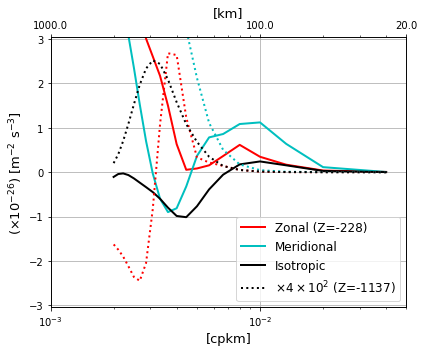

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


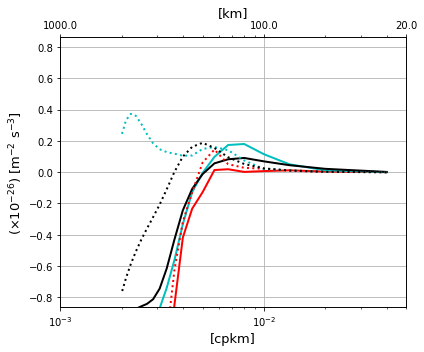

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


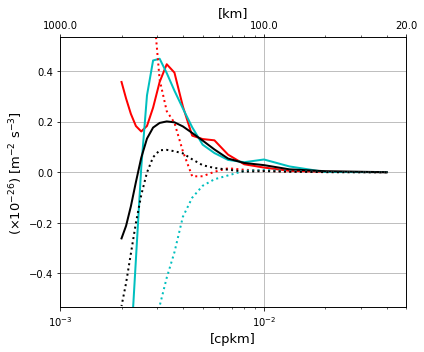

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


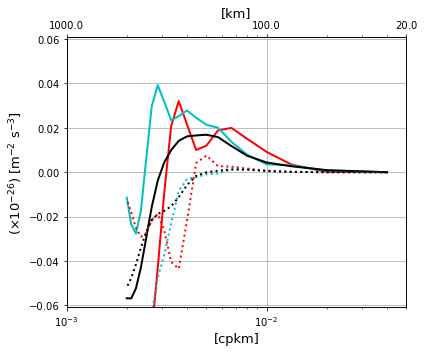

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


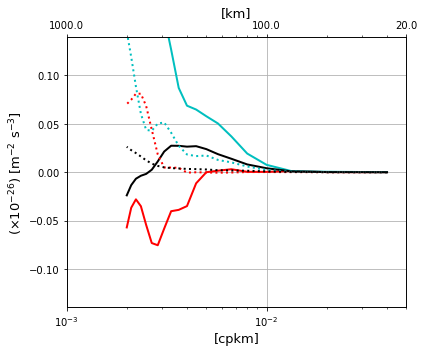

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


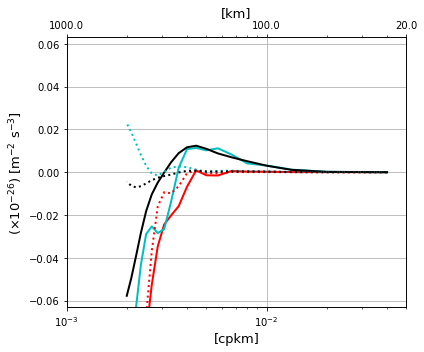

In [9]:
for reg in range(len(xs)):
    
    ds = xr.open_dataset(op.join(savedir,'AdvPVTrans_region%02d_1967-01-03_08.zarr' % reg))
#             eta = -(iso_csQAq*np.diff(iso_csQAq.scale**-1)[0])[::-1].cumsum('scale')[::-1]
    eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
           * np.abs(np.diff(ds.scale**-1)[0])).cumsum('scale').compute()
#     print(eta)

    fig, ax = plt.subplots(figsize=(6,5))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
    ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
                    'r', lw=2, label=r"Zonal (Z=-228)")
    ax.plot((eta.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e26,
                    'c', lw=2, label=r"Meridional")
    ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
                    'k', lw=2, label=r"Isotropic")
    ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=1).mean(['nmemb'])*4e28,
                     'r:', lw=2)
    ax.plot((eta.scale)**-1*1e3, eta.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*4e28,
                     'c:', lw=2)
    ax.plot((eta.scale)**-1*1e3, eta.isel(Z=1).mean(['nmemb','angle'])*4e28,
                     'k:', lw=2, label=r"$\times 4\times10^{2}$ (Z=-1137)")
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,5e-2])
    ax3.set_xlim([1e-3,5e-2])
    ax3.set_xticks([1e-3,1e-2,5e-2])
    ax3.set_xticklabels([1e3,1e2,2e1])
    Meta = np.fmax(np.fmax(np.abs(eta.isel(Z=0).mean(['nmemb','angle'])).max(skipna=True).values*1e26,
                                   np.abs(eta.isel(Z=0,angle=0).mean(['nmemb'])).max(skipna=True).values*1e26),
                           np.abs(eta.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])).max(skipna=True).values*1e26
                          )
    ax.set_ylim([-.5*Meta, .5*Meta])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-26}$) [m$^{-2}$ s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='lower right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/Ens-specflux_Region%02d.pdf' % reg))
    plt.show()